In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [46]:
df = pd.read_csv('./movie_metadata.csv')
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


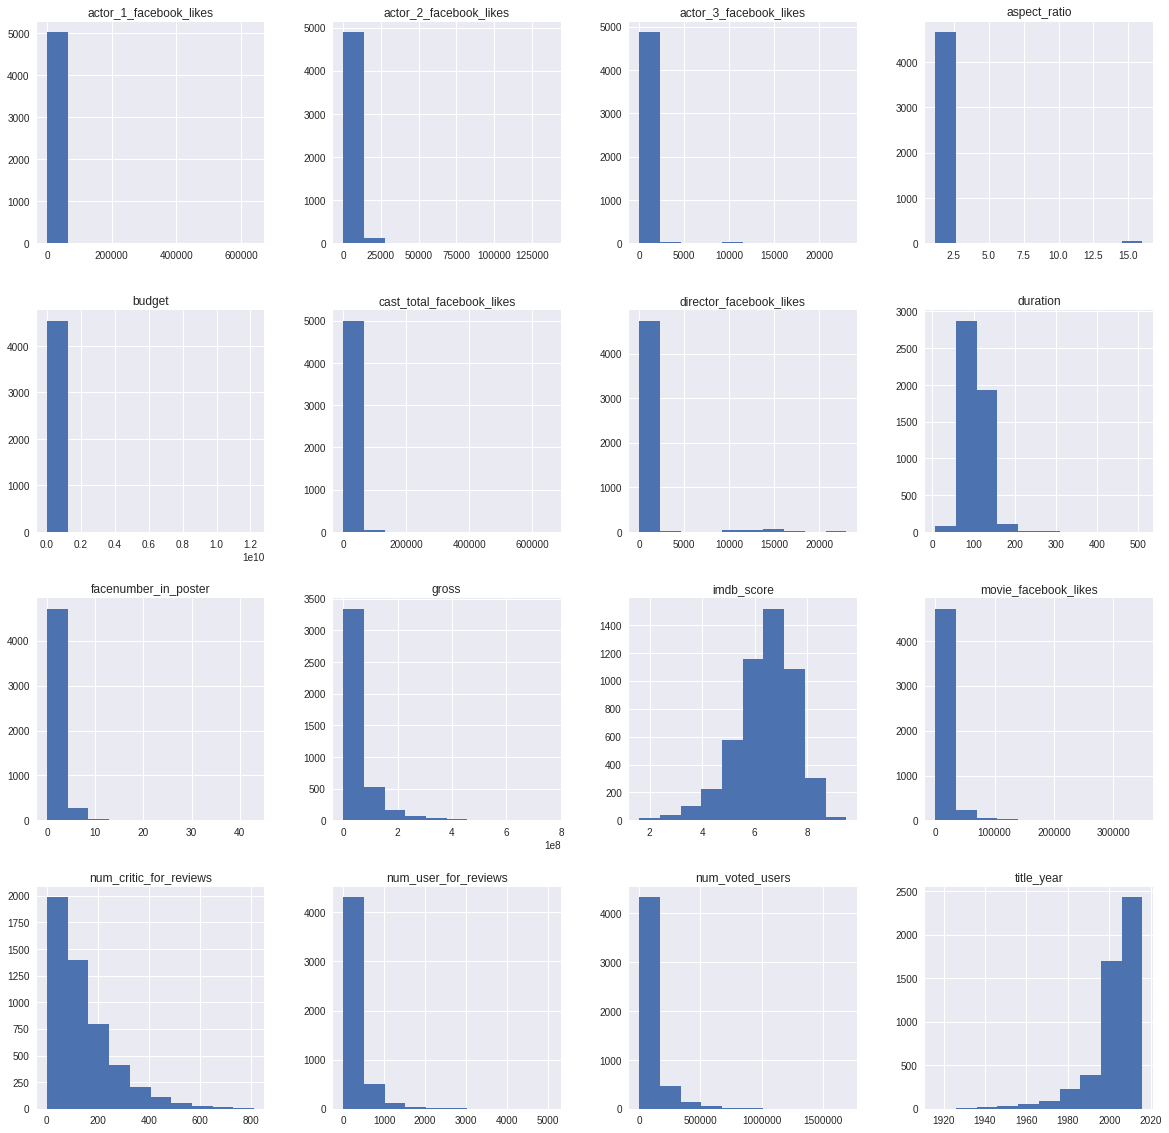

In [47]:
# show histograms
plt.style.use('seaborn')
df.hist(figsize=[20,20])
plt.show()

In [48]:
# remove duplicates
df = df.drop_duplicates(subset='movie_title', keep='first')

# count NaNs
nandata = df.isnull().sum().to_frame('Number of NaN')

# fill NaN with median and mode
median = df[['num_critic_for_reviews', 'director_facebook_likes',
             'actor_3_facebook_likes', 'actor_1_facebook_likes', 
             'num_user_for_reviews', 'gross', 'budget',
             'actor_2_facebook_likes', 'movie_facebook_likes']].median()

df = df.fillna(median)

mode = df[['color', 'duration', 'facenumber_in_poster', 'language',
           'country', 'content_rating', 'title_year', 'aspect_ratio']].mode().iloc[0]

df = df.fillna(mode)

# float to int
df[['num_critic_for_reviews','director_facebook_likes','actor_3_facebook_likes','actor_1_facebook_likes','facenumber_in_poster','num_user_for_reviews','title_year','actor_2_facebook_likes']]=df[['num_critic_for_reviews','director_facebook_likes','actor_3_facebook_likes','actor_1_facebook_likes','facenumber_in_poster','num_user_for_reviews','title_year','actor_2_facebook_likes']].astype(int)

# drop any remaining NaNs
df = df.dropna()

# select text columns
name_cols = [x for x in df.columns if 'name' in x]
text_cols = name_cols + ['plot_keywords', 'movie_imdb_link']

# drop text columns
df = df.drop(text_cols, axis=1)

In [49]:
# get a set of all generes
ALL_GEN = set()
for val in df.genres.unique():
    val = val.split('|')
    for v in val:
        ALL_GEN.add(v)
        
def generes_to_onehot(row):
    """Converts pipe-separated 'genere' feature to one-hot."""
    genere_dict = {genere: 0 for genere in ALL_GEN}
    for genere in ALL_GEN:
        if genere in row:
            genere_dict[genere] = 1     
    return pd.Series(genere_dict)

# add one, one-hot feature for each genere
df = df.merge(df.genres.apply(lambda x: generes_to_onehot(x)), left_index=True, right_index=True)

# drop old, pipe-separated genere feature
df = df.drop(['genres'], axis=1)

In [50]:
def color_to_onehot(row):
    """Converts color feature to one hot encoding."""
    if row == 'Color':
        return 1
    elif row == ' Black and White':
        return 0
    else:
        raise Exception('Wrong value')

df['color'] = df['color'].apply(lambda x: color_to_onehot(x))

In [51]:
# drop remaining categorical features
df = df.drop(['language', 'country', 'content_rating'], axis=1)

In [52]:
df = df.set_index('movie_title')

def strip_arr(arr):
    """Strips array of string values."""
    return np.array([elem.strip() for elem in arr])

# normalize data
sclr = MinMaxScaler()
scaled = sclr.fit_transform(df)
df = pd.DataFrame(scaled, columns=strip_arr(df.columns.values),
                  index=strip_arr(df.index.values))


/home/kuba/anaconda3/envs/lsh_tf36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [53]:
df.head()

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,...,Film-Noir,Family,Crime,Short,Biography,Animation,Horror,News,Thriller,Musical
Avatar,1.0,0.889163,0.529412,0.000000,0.037174,0.001563,1.000000,0.524453,0.007361,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pirates of the Caribbean: At World's End,1.0,0.370690,0.501548,0.024478,0.043478,0.062500,0.406840,0.278865,0.073622,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spectre,1.0,0.740148,0.436533,0.000000,0.007000,0.017188,0.263080,0.163256,0.017816,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
The Dark Knight Rises,1.0,1.000000,0.486068,0.956522,1.000000,0.042188,0.589253,0.677216,0.162561,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
John Carter,1.0,0.567734,0.386997,0.020652,0.023043,0.001000,0.096066,0.125579,0.002852,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# save preprocessed dataset to .csv file
df.to_csv('./dataset.csv', index=True)